In [32]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet, BayesianRidge, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

1. Исходные данные

In [33]:
# Фиксация генератора случайных чисел
random_seed = 1903    # 1944 1906      # 1961 1956 1922 1911
np.random.seed(random_seed)

# Значения предикторов для прогноза целевой переменной
A_complex_max = [1800 + 1000j, 1500 + 1000j, 1800 + 1400j, 2000 + 1700j, 1500 + 1200j]
# A_complex_max = [600 + 200j, 240 + 170j, 700 + 320j, 800 + 300j, 400 + 150j]

# Отн. погрешности измерений значений элементов матрицы A_h и вектора b_d
k_A = 0.01
k_b = 0.05

# Относительный размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [34]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_complex_acc = pd.read_excel('C:\Datasets/dataset_z_complex_reg_acc.xlsx').astype(complex)
z_complex_acc.T

,0,1,2,3,4
0,0.04+0.02j,0.035+0.015j,0.03+0.02j,0.020+0.012j,0.016+0.010j


In [35]:
# Загрузка датасета с данными из комплексных чисел
df_complex = pd.read_excel('C:\Datasets/dataset_complex_reg_1.xlsx').astype(complex)
df_complex

,A_h_1,A_h_2,A_h_3,A_h_4,A_h_5,b_d
0,400.551003+150.206626j,198.309353+99.154677j,450.976315+200.433918j,604.769973+251.987489j,200.179627+100.089814j,39.491479+51.681451j
1,404.555551+151.708332j,202.231387+101.115694j,455.748484+202.554882j,610.383972+254.326655j,203.047404+101.523702j,41.062879+53.745167j
2,409.498203+153.561826j,206.468286+103.234143j,458.061881+203.583058j,619.980687+258.325286j,202.497154+101.248577j,38.755485+50.721141j
3,410.464119+153.924045j,206.471537+103.235769j,463.702654+206.090068j,626.817637+261.174015j,205.170384+102.585192j,42.162467+55.185575j
4,413.355916+155.008468j,207.056153+103.528077j,469.752997+208.779110j,630.087949+262.536645j,203.485288+101.742644j,41.762503+54.640837j
...,...,...,...,...,...,...
95,813.187665+304.945374j,413.080081+206.540040j,914.629324+406.501922j,1193.708233+497.378430j,434.451853+217.225927j,79.883679+104.620703j
96,821.994064+308.247774j,414.487860+207.243930j,930.778947+413.679532j,1186.914628+494.547762j,439.240190+219.620095j,77.726522+101.809238j
97,822.664343+308.499129j,420.805697+210.402848j,943.381340+419.280596j,1189.353666+495.564028j,445.422660+222.711330j,77.078618+100.999084j
98,832.029027+312.010885j,427.866796+213.933398j,951.331564+422.814028j,1214.309393+505.962247j,443.085808+221.542904j,80.871598+105.968838j


3. Попарные графики рассеяния модулей значений переменных датасета

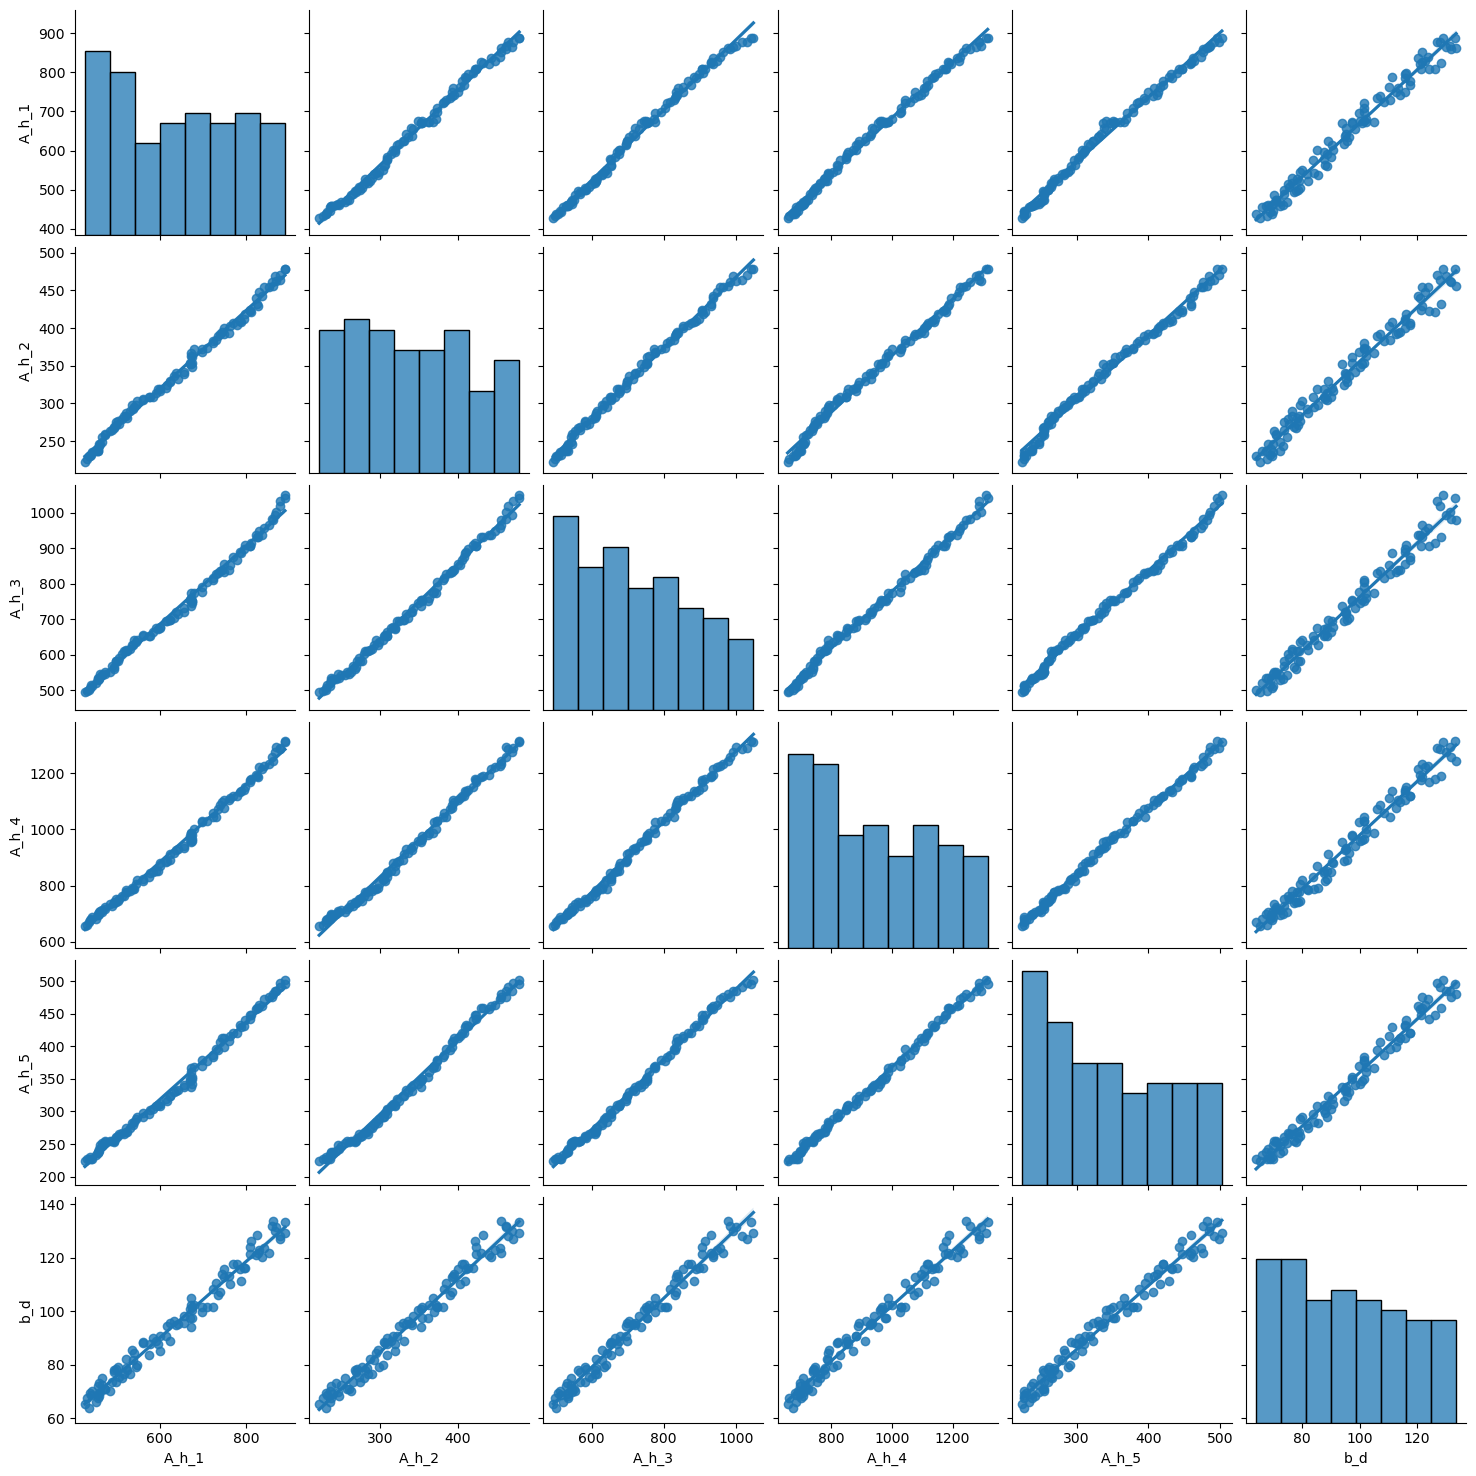

In [36]:
df_modul = df_complex.applymap(lambda x: abs(x))
sns.pairplot(df_modul, kind="reg")
plt.show()

4. Выделение комплексной матрицы признаков и комплексного вектора целевой переменной из датасета df_complex

In [37]:
A_complex = df_complex.iloc[:, :-1].values
b_complex = df_complex.iloc[:, -1].values
cond_A_complex = np.linalg.cond(A_complex.T @ A_complex)
det_A_complex = np.linalg.det(A_complex.T @ A_complex)

print(f'Число обусловленности матрицы A_complex: cond(A_complex) = {cond_A_complex.round(1)}')
print("Определитель матрицы A_complex:", det_A_complex)

Число обусловленности матрицы A_complex: cond(A_complex) = 125512.2
Определитель матрицы A_complex: (-1.58731104949958e+23-2.8097952598019892e+23j)


5. Разбиение на обучающую и тестовые выборки

In [38]:
A_train_complex, A_test_complex, b_train_complex, b_test_complex = train_test_split(A_complex, 
                                                                                    b_complex,
                                                                                    test_size=test_size,
                                                                                    random_state=random_seed)

6. Формирование вещественной матрицы A_train признаков и вещественного вектора b_train целевой переменной

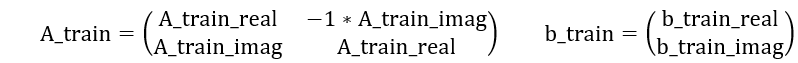


In [39]:
A_train_real = A_train_complex.real
A_train_imag = A_train_complex.imag
A_train_1 = pd.concat([pd.DataFrame(A_train_real), pd.DataFrame(A_train_imag)], axis=0)
A_train_2 = pd.concat([-1 * pd.DataFrame(A_train_imag), pd.DataFrame(A_train_real)], axis=0)
index_train = np.arange(A_train_1.shape[0])
A_train_1.index = index_train
A_train_2.index = index_train 
A_train = pd.merge(A_train_1, A_train_2, left_index=True, right_index=True)
A_train.columns = [f'A_{i+1}' for i in range(A_train.shape[1])]

In [40]:
b_train_real = b_train_complex.real
b_train_imag = b_train_complex.imag
b_train = pd.concat([pd.DataFrame(b_train_real), pd.DataFrame(b_train_imag)], axis=0)
b_train.index = index_train
b_train.columns = ['b']

7. Формирование вещественной матрицы A_test признаков и вещественного вектора b_test целевой переменной

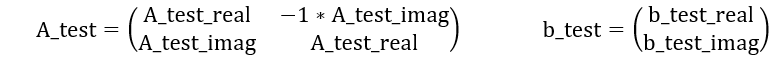

In [41]:
A_test_real = A_test_complex.real
A_test_imag = A_test_complex.imag
A_test_1 = pd.concat([pd.DataFrame(A_test_real), pd.DataFrame(A_test_imag)], axis=0)
A_test_2 = pd.concat([-1 * pd.DataFrame(A_test_imag), pd.DataFrame(A_test_real)], axis=0)
index_test = np.arange(A_test_1.shape[0])
A_test_1.index = index_test
A_test_2.index = index_test 
A_test = pd.merge(A_test_1, A_test_2, left_index=True, right_index=True)
A_test.columns = [f'A_{i+1}' for i in range(A_test.shape[1])]

In [42]:
b_test_real = b_test_complex.real
b_test_imag = b_test_complex.imag
b_test = pd.concat([pd.DataFrame(b_test_real), pd.DataFrame(b_test_imag)], axis=0)
b_test.index = index_test
b_test.columns = ['b']

8. Формирование вещественного вектора A_max для прогноза целевой переменной

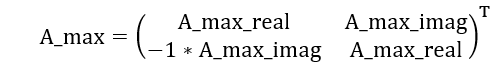

In [43]:
A_max_real = np.array(A_complex_max).real
A_max_imag = np.array(A_complex_max).imag
A_max_1 = pd.concat([pd.DataFrame(A_max_real), -1 * pd.DataFrame(A_max_imag)], axis=0)
A_max_2 = pd.concat([pd.DataFrame(A_max_imag), pd.DataFrame(A_max_real)], axis=0)
index_max = np.arange(A_max_1.shape[0])
A_max_1.index = index_max
A_max_2.index = index_max 
A_max = pd.merge(A_max_1, A_max_2, left_index=True, right_index=True)
A_max = A_max.T
A_max

,0,1,2,3,4,5,6,7,8,9
0_x,1800.0,1500.0,1800.0,2000.0,1500.0,-1000.0,-1000.0,-1400.0,-1700.0,-1200.0
0_y,1000.0,1000.0,1400.0,1700.0,1200.0,1800.0,1500.0,1800.0,2000.0,1500.0


9. Масштабирование признаков и вектора A_max

In [44]:
sc = MaxAbsScaler()    # MaxAbsScaler()    StandardScaler()

# Переход к привычным обозначениям X и y для признаков и целевых переменных
X_train_std = sc.fit_transform(A_train) 
X_test_std = sc.transform(A_test)
# X_train_std = A_train 
# X_test_std = A_test

y_train = b_train
y_test = b_test

In [45]:
A_max_std = sc.transform(A_max)
# A_max_std = A_max
pd.DataFrame(A_max_std).round(3)

,0,1,2,3,4,5,6,7,8,9
0,2.162,3.506,1.878,1.647,3.339,-1.201,-2.337,-1.460,-1.400,-2.671
1,1.201,2.337,1.460,1.400,2.671,2.162,3.506,1.878,1.647,3.339


10. Обучение моделей регрессоров на train-данных

In [46]:
metrics = {}

10.1 LinearRegression

In [47]:
lr = LinearRegression()
model_lr = lr.fit(X_train_std, y_train)

y_lr_pred = model_lr.predict(X_test_std)
y_lr_pred_train = model_lr.predict(X_train_std)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_lr_pred_train)).round(3)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_lr_pred)).round(3)
mae_lr_train = mean_absolute_error(y_train, y_lr_pred_train).round(3)
mae_lr_test = mean_absolute_error(y_test, y_lr_pred).round(3)
r2_lr_train = r2_score(y_train, y_lr_pred_train).round(3)
r2_lr_test = r2_score(y_test, y_lr_pred).round(3)

b_max_lr = model_lr.predict(A_max_std)[:].flatten()
b_max_lr_complex = complex(b_max_lr[0], b_max_lr[1])
b_max_lr_modul = np.abs(b_max_lr_complex)
b_max_lr_arg = np.angle(b_max_lr_complex) * 180 / np.pi
metrics['LinearRegr'] = (str(r2_lr_train), str(r2_lr_test), np.round(b_max_lr_complex, 1), str(b_max_lr_modul.round(1)), str(b_max_lr_arg.round(1)))

print(f'RMSE train: {rmse_lr_train}')
print(f'RMSE test:  {rmse_lr_test}')
print()
print(f'MAE train:  {mae_lr_train}')
print(f'MAE test:   {mae_lr_test}')
print()
print(f'R2 train:   {r2_lr_train}')
print(f'R2 test:    {r2_lr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lr_complex, 1)}')
print(f'b max_modul:   {b_max_lr_modul.round(1)}')
print()
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')
print('Масштабированные коэффициенты регрессии:')
pd.DataFrame({'z_real': model_lr.coef_.flatten()[:len(A_complex_max)], 'z_imag': model_lr.coef_.flatten()[len(A_complex_max):]}).T.round(1)

RMSE train: 1.999
RMSE test:  1.942

MAE train:  1.722
MAE test:   1.716

R2 train:   0.986
R2 test:    0.985

Прогноз целевой переменной:
b max_complex: (208.3+343.9j)
b max_modul:   402.0

Свободный член регрессии  a0 =  [6.117]
Масштабированные коэффициенты регрессии:


,0,1,2,3,4
z_real,63.9,21.8,7.7,-30.7,35.3
z_imag,34.7,9.9,9.6,-8.0,9.8


10.2 Ridge

In [48]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_train_std, y_train)

y_rid_pred = model_rid.predict(X_test_std)
y_rid_pred_train = model_rid.predict(X_train_std)

rmse_rid_train = np.sqrt(mean_squared_error(y_train, y_rid_pred_train)).round(3)
rmse_rid_test = np.sqrt(mean_squared_error(y_test, y_rid_pred)).round(3)
mae_rid_train = mean_absolute_error(y_train, y_rid_pred_train).round(3)
mae_rid_test = mean_absolute_error(y_test, y_rid_pred).round(3)
r2_rid_train = r2_score(y_train, y_rid_pred_train).round(3)
r2_rid_test = r2_score(y_test, y_rid_pred).round(3)

b_max_rid = model_rid.predict(A_max_std)[:].flatten()
b_max_rid_complex = complex(b_max_rid[0], b_max_rid[1])
b_max_rid_modul = np.abs(b_max_rid_complex)
b_max_rid_arg = np.angle(b_max_rid_complex) * 180 / np.pi
metrics['Ridge'] = (str(r2_rid_train), str(r2_rid_test), np.round(b_max_rid_complex, 1), str(b_max_rid_modul.round(1)), str(b_max_rid_arg.round(1)))

print(f'RMSE train: {rmse_rid_train}')
print(f'RMSE test:  {rmse_rid_test}')
print()
print(f'MAE train:  {mae_rid_train}')
print(f'MAE test:   {mae_rid_test}')
print()
print(f'R2 train:   {r2_rid_train}')
print(f'R2 test:    {r2_rid_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_rid_complex, 1)}')
print(f'b max_modul:   {b_max_rid_modul.round(1)}')
model_rid.best_params_

RMSE train: 2.037
RMSE test:  2.003

MAE train:  1.753
MAE test:   1.684

R2 train:   0.986
R2 test:    0.984

Прогноз целевой переменной:
b max_complex: (166.9+329.5j)
b max_modul:   369.4


{'alpha': 0.05754399373371572, 'random_state': 1}

10.3 Lasso

In [49]:
lass = Lasso()
lass_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_lass = GridSearchCV(estimator=lass,
                   param_grid=lass_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_lass.fit(X_train_std, y_train)

y_lass_pred = model_lass.predict(X_test_std)
y_lass_pred_train = model_lass.predict(X_train_std)

rmse_lass_train = np.sqrt(mean_squared_error(y_train, y_lass_pred_train)).round(3)
rmse_lass_test = np.sqrt(mean_squared_error(y_test, y_lass_pred)).round(3)
mae_lass_train = mean_absolute_error(y_train, y_lass_pred_train).round(3)
mae_lass_test = mean_absolute_error(y_test, y_lass_pred).round(3)
r2_lass_train = r2_score(y_train, y_lass_pred_train).round(3)
r2_lass_test = r2_score(y_test, y_lass_pred).round(3)

b_max_lass = model_lass.predict(A_max_std)[:].flatten()
b_max_lass_complex = complex(b_max_lass[0], b_max_lass[1])
b_max_lass_modul = np.abs(b_max_lass_complex)
b_max_lass_arg = np.angle(b_max_lass_complex) * 180 / np.pi
metrics['Lasso'] = (str(r2_lass_train), str(r2_lass_test), np.round(b_max_lass_complex, 1), str(b_max_lass_modul.round(1)), str(b_max_lass_arg.round(1)))

print(f'RMSE train: {rmse_lass_train}')
print(f'RMSE test:  {rmse_lass_test}')
print()
print(f'MAE train:  {mae_lass_train}')
print(f'MAE test:   {mae_lass_test}')
print()
print(f'R2 train:   {r2_lass_train}')
print(f'R2 test:    {r2_lass_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lass_complex, 1)}')
print(f'b max_modul:   {b_max_lass_modul.round(1)}')
model_lass.best_params_

RMSE train: 2.006
RMSE test:  1.947

MAE train:  1.711
MAE test:   1.717

R2 train:   0.986
R2 test:    0.985

Прогноз целевой переменной:
b max_complex: (220.4+327.8j)
b max_modul:   395.0


{'alpha': 1e-05, 'random_state': 1}

10.4 ElasticNet

In [50]:
en = ElasticNet()
en_parameters = {'alpha': np.logspace(-5, 3, num=101),
                 'l1_ratio': (0.05, 0.1, 0.3, 0.5, 0.7, 0.9),
                 'random_state':[1, 7, 42, 100]
}
model_en = GridSearchCV(estimator=en,
                   param_grid=en_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_en.fit(X_train_std, y_train)

y_en_pred = model_en.predict(X_test_std)
y_en_pred_train = model_en.predict(X_train_std)

rmse_en_train = np.sqrt(mean_squared_error(y_train, y_en_pred_train)).round(3)
rmse_en_test = np.sqrt(mean_squared_error(y_test, y_en_pred)).round(3)
mae_en_train = mean_absolute_error(y_train, y_en_pred_train).round(3)
mae_en_test = mean_absolute_error(y_test, y_en_pred).round(3)
r2_en_train = r2_score(y_train, y_en_pred_train).round(3)
r2_en_test = r2_score(y_test, y_en_pred).round(3)

b_max_en = model_en.predict(A_max_std).flatten()
b_max_en_complex = complex(b_max_en[0], b_max_en[1])
b_max_en_modul = np.abs(b_max_en_complex)
b_max_en_arg = np.angle(b_max_en_complex) * 180 / np.pi
metrics['ElasticNet'] = (str(r2_en_train), str(r2_en_test), np.round(b_max_en_complex, 1), str(b_max_en_modul.round(1)), str(b_max_en_arg.round(1)))

print(f'RMSE train: {rmse_en_train}')
print(f'RMSE test:  {rmse_en_test}')
print()
print(f'MAE train:  {mae_en_train}')
print(f'MAE test:   {mae_en_test}')
print()
print(f'R2 train:   {r2_en_train}')
print(f'R2 test:    {r2_en_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_en_complex, 1)}')
print(f'b max_modul:   {b_max_en_modul.round(1)}')
model_en.best_params_

RMSE train: 2.006
RMSE test:  1.955

MAE train:  1.711
MAE test:   1.721

R2 train:   0.986
R2 test:    0.985

Прогноз целевой переменной:
b max_complex: (217.1+327.2j)
b max_modul:   392.7


{'alpha': 1e-05, 'l1_ratio': 0.5, 'random_state': 1}

10.5 TheilSenRegressor

In [51]:
tsr = TheilSenRegressor()
tsr_parameters = {'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_train_std, y_train)

y_tsr_pred = model_tsr.predict(X_test_std)
y_tsr_pred_train = model_tsr.predict(X_train_std)

rmse_tsr_train = np.sqrt(mean_squared_error(y_train, y_tsr_pred_train)).round(3)
rmse_tsr_test = np.sqrt(mean_squared_error(y_test, y_tsr_pred)).round(3)
mae_tsr_train = mean_absolute_error(y_train, y_tsr_pred_train).round(3)
mae_tsr_test = mean_absolute_error(y_test, y_tsr_pred).round(3)
r2_tsr_train = r2_score(y_train, y_tsr_pred_train).round(3)
r2_tsr_test = r2_score(y_test, y_tsr_pred).round(3)

b_max_tsr = model_tsr.predict(A_max_std).flatten()
b_max_tsr_complex = complex(b_max_tsr[0], b_max_tsr[1])
b_max_tsr_modul = np.abs(b_max_tsr_complex)
b_max_tsr_arg = np.angle(b_max_tsr_complex) * 180 / np.pi
metrics['TheilSenRegr'] = (str(r2_tsr_train), str(r2_tsr_test), np.round(b_max_tsr_complex, 1), str(b_max_tsr_modul.round(1)), str(b_max_tsr_arg.round(1)))

print(f'RMSE train: {rmse_tsr_train}')
print(f'RMSE test:  {rmse_tsr_test}')
print()
print(f'MAE train:  {mae_tsr_train}')
print(f'MAE test:   {mae_tsr_test}')
print()
print(f'R2 train:   {r2_tsr_train}')
print(f'R2 test:    {r2_tsr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_tsr_complex, 1)}')
print(f'b max_modul:   {b_max_tsr_modul.round(1)}')
model_tsr.best_params_

RMSE train: 2.005
RMSE test:  1.936

MAE train:  1.74
MAE test:   1.705

R2 train:   0.986
R2 test:    0.985

Прогноз целевой переменной:
b max_complex: (194.9+341.7j)
b max_modul:   393.4


{'random_state': 1}

11. Средние значения метрик регрессоров и целевой переменной b

In [52]:
r2_train_values = [metrics[key][-5] for key in metrics]
r2_train_values = [float(value) for value in r2_train_values[:-1]]
r2_train_mean = round(sum(r2_train_values) / len(r2_train_values), 3)
r2_test_values = [metrics[key][-4] for key in metrics]
r2_test_values = [float(value) for value in r2_test_values[:-1]]
r2_test_mean = round(sum(r2_test_values) / len(r2_test_values), 3)

b_max_values = [metrics[key][-3] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
b_max_mean_complex = b_max_mean
b_max_mean_modul = np.abs(b_max_mean_complex)
b_max_mean_arg = np.angle(b_max_mean_complex) * 180 / np.pi
metrics['Mean'] = (str(r2_train_mean), str(r2_test_mean), np.round(b_max_mean_complex, 1), str(b_max_mean_modul.round(1)), str(b_max_mean_arg.round(1)))

print(f'Средние значения прогноза целевой переменной различными регрессорами:')
print(f'b_max_mean_complex: {np.round(b_max_mean_complex, 1)}')
print(f'b_max_mean_modul:   {b_max_mean_modul.round(1)}')

Средние значения прогноза целевой переменной различными регрессорами:
b_max_mean_complex: (201.5+334j)
b_max_mean_modul:   390.1


12. Обучение Feed Forward Neural Network

In [53]:
# Определение функции коэффициента детерминации R2
def r_squared(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (SS_res / SS_tot)


# Задание диапазона значений для числа слоев и числа нейронов
num_neurons_range = range(8, 25, 4)

# Задание диапазона значений для seed_value
seed_values = range(1900, 1911)

# Инициализация переменных для сохранения лучшей модели
best_r2 = -np.inf
sum_r2 = -np.inf

# Цикл обучения моделей с разным числом нейронов на каждом слое
for num_neurons_1 in num_neurons_range:
    for num_neurons_2 in num_neurons_range:
        print(f'Number of neurons in Layer 1: {num_neurons_1}, Number of neurons in Layer 2: {num_neurons_2}')
        
        for seed_value in seed_values:
            
            # Установка seed_value для генератора случайных чисел
            random.seed(seed_value)
            np.random.seed(seed_value)
            tf.random.set_seed(seed_value)

            model = Sequential()
            model.add(Dense(num_neurons_1, activation='relu', input_shape=(X_train_std.shape[1],)))
            model.add(Dense(num_neurons_2, activation='relu'))
            model.add(Dense(1, activation='linear'))

            model.compile(optimizer='adam', loss='mean_squared_error')
            early_stop = EarlyStopping(monitor='val_loss', patience=10)
            history = model.fit(X_train_std, y_train, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=0)

            y_pred = model.predict(X_test_std)
            y_pred_train = model.predict(X_train_std)
            r2 = r_squared(np.ravel(y_test), np.ravel(y_pred))
            r2_train = r_squared(np.ravel(y_train), np.ravel(y_pred_train))

            print(f'r2 train = {r2_train.round(7)}')
            print(f'r2 test  = {r2.round(7)}')
            print()

            if r2 > best_r2:
                best_r2 = r2
                best_num_neurons_1 = num_neurons_1
                best_num_neurons_2 = num_neurons_2
                best_seed = seed_value
                best_model = model
                best_history = history

            if r2 + r2_train > sum_r2:
                sum_r2 = r2 + r2_train
                balance_r2 = r2
                balance_num_neurons_1 = num_neurons_1
                balance_num_neurons_2 = num_neurons_2
                balance_seed = seed_value
                balance_model = model
                balance_history = history

Number of neurons in Layer 1: 8, Number of neurons in Layer 2: 8


5/5 [==============================] - 0s 2ms/step
r2 train = 0.9627054
r2 test  = 0.9483854

5/5 [==============================] - 0s 1ms/step
r2 train = 0.9587057
r2 test  = 0.9427102

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9320504
r2 test  = 0.9194015

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9558901
r2 test  = 0.9387497

5/5 [==============================] - 0s 2ms/step
r2 train = 0.8922892
r2 test  = 0.8863902

5/5 [==============================] - 0s 2ms/step
r2 train = -1.5109703
r2 test  = -1.435457

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9495021
r2 test  = 0.9304376

5/5 [==============================] - 0s 2ms/step
r2 train = -2.4523574
r2 test  = -2.484077

5/5 [==============================] - 0s 2ms/step
r2 train = 0.6634911
r2 test  = 0.6670941

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9533354
r2 test  = 0.9384142

5/5 [==============================] - 0s 2ms/step
r2 trai

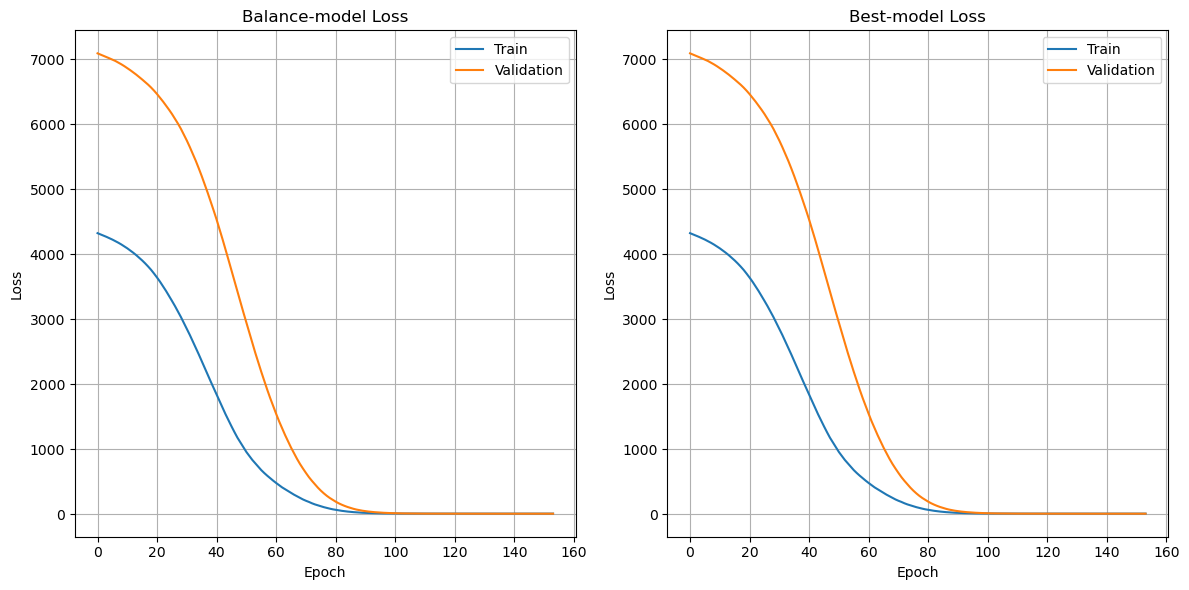

In [54]:
# Построение графиков функции потерь
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(balance_history.history['loss'])
plt.plot(balance_history.history['val_loss'])
plt.title('Balance-model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Best-model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

plt.tight_layout()  # Для более компактного расположения
plt.show()

In [55]:
print('R2_balance:', balance_r2.round(5))
print('Число нейронов на слое 1 для balance-модели:', balance_num_neurons_1)
print('Число нейронов на слое 2 для balance-модели:', balance_num_neurons_2)
print('Значение seed для balance-модели:', balance_seed)
print()
print('R2_best:',    best_r2.round(5))
print('Число нейронов на слое 1 для лучшей модели:',  best_num_neurons_1)
print('Число нейронов на слое 2 для лучшей модели:',  best_num_neurons_2)
print('Значение seed для best-модели:',    best_seed)

R2_balance: 0.96135
Число нейронов на слое 1 для balance-модели: 20
Число нейронов на слое 2 для balance-модели: 24
Значение seed для balance-модели: 1910

R2_best: 0.96135
Число нейронов на слое 1 для лучшей модели: 20
Число нейронов на слое 2 для лучшей модели: 24
Значение seed для best-модели: 1910


In [56]:
y_NN_pred_balance = balance_model.predict(X_test_std)
y_NN_pred_train_balance = balance_model.predict(X_train_std)

rmse_NN_train_balance = np.sqrt(mean_squared_error(y_train, y_NN_pred_train_balance)).round(3)
rmse_NN_test_balance = np.sqrt(mean_squared_error(y_test, y_NN_pred_balance)).round(3)
mae_NN_train_balance = mean_absolute_error(y_train, y_NN_pred_train_balance).round(3)
mae_NN_test_balance = mean_absolute_error(y_test, y_NN_pred_balance).round(3)
r2_NN_train_balance = r2_score(y_train, y_NN_pred_train_balance).round(3)
r2_NN_test_balance = r2_score(y_test, y_NN_pred_balance).round(3)

b_max_NN_balance = balance_model.predict(A_max_std)[:].flatten()
b_max_NN_complex_balance = complex(b_max_NN_balance[0], b_max_NN_balance[1])
b_max_NN_modul_balance = np.abs(b_max_NN_complex_balance)
b_max_NN_arg_balance = np.angle(b_max_NN_complex_balance) * 180 / np.pi
metrics['NeuralNet_balance'] = (str(r2_NN_train_balance), str(r2_NN_test_balance), np.round(b_max_NN_complex_balance, 1), str(b_max_NN_modul_balance.round(1)), str(b_max_NN_arg_balance.round(1)))

y_NN_pred = best_model.predict(X_test_std)
y_NN_pred_train = best_model.predict(X_train_std)

rmse_NN_train = np.sqrt(mean_squared_error(y_train, y_NN_pred_train)).round(3)
rmse_NN_test = np.sqrt(mean_squared_error(y_test, y_NN_pred)).round(3)
mae_NN_train = mean_absolute_error(y_train, y_NN_pred_train).round(3)
mae_NN_test = mean_absolute_error(y_test, y_NN_pred).round(3)
r2_NN_train = r2_score(y_train, y_NN_pred_train).round(3)
r2_NN_test = r2_score(y_test, y_NN_pred).round(3)

b_max_NN = best_model.predict(A_max_std)[:].flatten()
b_max_NN_complex = complex(b_max_NN[0], b_max_NN[1])
b_max_NN_modul = np.abs(b_max_NN_complex)
b_max_NN_arg = np.angle(b_max_NN_complex) * 180 / np.pi
metrics['NeuralNet_best'] = (str(r2_NN_train), str(r2_NN_test), np.round(b_max_NN_complex, 1), str(b_max_NN_modul.round(1)), str(b_max_NN_arg.round(1)))

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 20ms/step


In [57]:
print(f'Метрики для balance-модели:')
print(f'RMSE train: {rmse_NN_train_balance}')
print(f'RMSE test:  {rmse_NN_test_balance}')
print()
print(f'MAE train:  {mae_NN_train_balance}')
print(f'MAE test:   {mae_NN_test_balance}')
print()
print(f'R2 train:   {r2_score(y_train, y_NN_pred_train_balance).round(6)}')
print(f'R2 test:    {r2_score(y_test, y_NN_pred_balance).round(6)}')
print()
print(f'Метрики для best-модели:')
print(f'RMSE train: {rmse_NN_train}')
print(f'RMSE test:  {rmse_NN_test}')
print()
print(f'MAE train:  {mae_NN_train}')
print(f'MAE test:   {mae_NN_test}')
print()
print(f'R2 train:   {r2_score(y_train, y_NN_pred_train).round(6)}')
print(f'R2 test:    {r2_score(y_test, y_NN_pred).round(6)}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex_balance: {np.round(b_max_NN_complex_balance, 1)}')
print(f'b max_modul_balance:   {b_max_NN_modul_balance.round(1)}')
print()
print(f'b max_complex_best:    {np.round(b_max_NN_complex, 1)}')
print(f'b max_modul_best:      {b_max_NN_modul.round(1)}')

Метрики для balance-модели:
RMSE train: 2.797
RMSE test:  3.103

MAE train:  2.286
MAE test:   2.513

R2 train:   0.973556
R2 test:    0.961354

Метрики для best-модели:
RMSE train: 2.797
RMSE test:  3.103

MAE train:  2.286
MAE test:   2.513

R2 train:   0.973556
R2 test:    0.961354

Прогноз целевой переменной:
b max_complex_balance: (173.8+276.7j)
b max_modul_balance:   326.8

b max_complex_best:    (173.8+276.7j)
b max_modul_best:      326.8


13. Определение коэффициента регуляризации alpha методом обобщенной невязки

In [58]:
# Функция вычисления обобщенной невязки delta_residual
def calculate_delta_residual(alpha, X, y, h, d):
    z = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    residual = np.linalg.norm(X @ z - y)
    norm = np.linalg.norm(z)
    delta_residual = residual**2 - (h * norm + d)**2

    return delta_residual


X_h = X_train_std
y_d = y_train
# Вычисление точности задания матрицы A: h = ||A - A_h|| и вектора b: d = ||b - b_d||
h = k_A * np.linalg.norm(X_h)
d = k_b * np.linalg.norm(y_d)

# Поиск коэффициента регуляризации alpha
calculate_delta_residual_partial = partial(calculate_delta_residual, X=X_h, y=y_d, h=h, d=d)
# alpha = newton(calculate_delta_residual_partial, x0=1e-7, tol=1e-7, maxiter=1000)
# alpha = bisect(calculate_delta_residual_partial, 1e-7, 1e5)
alpha = brentq(calculate_delta_residual_partial, a=1e-7, b=1e5, xtol=1e-7)

print(f"Коэффициент регуляризации alpha = {alpha:.{2}e}")

Коэффициент регуляризации alpha = 1.33e+01


14. Регуляризированное решение системы уравнений

In [59]:
# Регуляризованное решение
z_hd = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d

y_reg_hd_pred = X_test_std @ z_hd
y_reg_hd_pred_train = X_train_std @ z_hd

rmse_reg_hd_train = np.sqrt(mean_squared_error(y_train, y_reg_hd_pred_train)).round(3)
rmse_reg_hd_test = np.sqrt(mean_squared_error(y_test, y_reg_hd_pred)).round(3)
mae_reg_hd_train = mean_absolute_error(y_train, y_reg_hd_pred_train).round(3)
mae_reg_hd_test = mean_absolute_error(y_test, y_reg_hd_pred).round(3)
r2_reg_hd_train = r2_score(y_train, y_reg_hd_pred_train).round(3)
r2_reg_hd_test = r2_score(y_test, y_reg_hd_pred).round(3)

b_max_reg_hd = np.dot(np.array(A_max_std), np.array(z_hd))
b_max_reg_hd_complex = complex(b_max_reg_hd[0], b_max_reg_hd[1])
b_max_reg_hd_modul = np.abs(b_max_reg_hd_complex)
b_max_reg_hd_arg = np.angle(b_max_reg_hd_complex) * 180 / np.pi
metrics['Regularized'] = (str(r2_reg_hd_train), str(r2_reg_hd_test), np.round(b_max_reg_hd_complex, 1), str(b_max_reg_hd_modul.round(1)), str(b_max_reg_hd_arg.round(1)))

print(f'RMSE train: {rmse_reg_hd_train}')
print(f'RMSE test:  {rmse_reg_hd_test}')
print()
print(f'MAE train:  {mae_reg_hd_train}')
print(f'MAE test:   {mae_reg_hd_test}')
print()
print(f'R2 train:   {r2_reg_hd_train}')
print(f'R2 test:    {r2_reg_hd_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b_max_reg_hd_complex: {np.round(b_max_reg_hd_complex, 1)}')
print(f'b_max_reg_hd_modul:   {b_max_reg_hd_modul.round(1)}')
print()

df_z_hd = pd.DataFrame(z_hd)
file_path = 'C:\Datasets/dataset_z_hd.xlsx'
df_z_hd.to_excel(file_path, index=False, float_format='%.20f')

z_hd_xy = z_hd.values.flatten()
z_hd_real = z_hd_xy[:len(A_complex_max)]
z_hd_imag = z_hd_xy[len(A_complex_max):]
print(f'Масштабированные коэффициенты регрессии после регуляризации:')
pd.DataFrame({'z_real': z_hd_real, 'z_imag': z_hd_imag}).T.round(1)

RMSE train: 4.475
RMSE test:  4.206

MAE train:  3.947
MAE test:   3.68

R2 train:   0.932
R2 test:    0.929

Прогноз целевой переменной:
b_max_reg_hd_complex: (160+325.1j)
b_max_reg_hd_modul:   362.3

Масштабированные коэффициенты регрессии после регуляризации:


,0,1,2,3,4
z_real,19.7,21.6,20.2,20.2,20.8
z_imag,12.3,10.6,11.0,11.7,10.1


In [60]:
# N_feat = X_h.shape[1]

# print("Точные масштабированные коэффициенты регрессии:")
# for i in range(0, N_feat): 
#     print((np.array(z_complex_acc)[i] * np.amax(A[:, i])).round(2))
# print()
# print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
# print("Регуляризованные масштабированные коэффициенты регрессии:")
# for i in range(0, N_feat): 
#     print(z_hd[i].round(2))

15. Условно точный прогноз целевой переменной b

In [61]:
b_max_acc_complex = np.dot(np.array(A_complex_max), np.array(z_complex_acc)).round(3)
b_max_acc_modul = abs(b_max_acc_complex).round(3)
b_max_acc_arg = np.angle(b_max_acc_complex) * 180 / np.pi
metrics['Accurate'] = ('', '', str(b_max_acc_complex.round(1)), str(b_max_acc_modul.round(1)), str(b_max_acc_arg.round(1)))

print(f'Условно точный прогноз целевой переменной по известным точным коэффициентам регрессии:')
print(f'b_max_acc_complex: {b_max_acc_complex[0]}')
print(f'b_max_acc_modul: {b_max_acc_modul[0]}')

Условно точный прогноз целевой переменной по известным точным коэффициентам регрессии:
b_max_acc_complex: (147.1+303.7j)
b_max_acc_modul: 337.449


16. Сводная таблица метрик и прогнозов моделей

In [62]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2 train', 'R2 test', 'b_max_complex', 'b_max_modul', 'b_max_arg, DEG']
df_metrics = df_metrics.astype(object)
df_metrics

,LinearRegr,Ridge,Lasso,ElasticNet,TheilSenRegr,Mean,NeuralNet_balance,NeuralNet_best,Regularized,Accurate
R2 train,0.986,0.986,0.986,0.986,0.986,0.986,0.974,0.974,0.932,
R2 test,0.985,0.984,0.985,0.985,0.985,0.985,0.961,0.961,0.929,
b_max_complex,(208.3+343.9j),(166.9+329.5j),(220.4+327.8j),(217.1+327.2j),(194.9+341.7j),(201.5+334j),(173.8+276.7j),(173.8+276.7j),(160+325.1j),[147.1+303.7j]
b_max_modul,402.0,369.4,395.0,392.7,393.4,390.1,326.8,326.8,362.3,[337.4]
"b_max_arg, DEG",58.8,63.1,56.1,56.4,60.3,58.9,57.9,57.9,63.8,[64.2]
